# Baseline tarea 1

-----------------------------




## Importar librerías y utiles

In [1]:
import pandas as pd
import shutil

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, confusion_matrix, cohen_kappa_score, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from nltk.sentiment.util import mark_negation

import matplotlib.pyplot as plt
import os
import numpy as np

## Datos

### Obtener los datasets desde el github del curso

In [2]:
train = {
    'anger': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/anger-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity']),
    'fear': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/fear-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity']),
    'joy': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/joy-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity']),
    'sadness': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/train/sadness-train.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'])
}

target = {
    'anger': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/anger-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE']),
    'fear': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/fear-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE']),
    'joy': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/joy-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE']),
    'sadness': pd.read_csv('https://raw.githubusercontent.com/dccuchile/CC6205/master/assignments/assignment_1/data/target/sadness-target.txt', sep='\t', names=['id', 'tweet', 'class', 'sentiment_intensity'], na_values=['NONE'])
}

data_keys = ['anger','fear','joy','sadness']

### Analizar los datos 

Imprimir la cantidad de tweets de cada dataset, según su intensidad de sentimiento

In [3]:
def get_group_dist(group_name, train):
    print(group_name, "\n",
          train[group_name].groupby('sentiment_intensity').count())


for key in train:
    get_group_dist(key, train)

anger 
                       id  tweet  class
sentiment_intensity                   
high                 163    163    163
low                  161    161    161
medium               617    617    617
fear 
                       id  tweet  class
sentiment_intensity                   
high                 270    270    270
low                  288    288    288
medium               699    699    699
joy 
                       id  tweet  class
sentiment_intensity                   
high                 195    195    195
low                  219    219    219
medium               488    488    488
sadness 
                       id  tweet  class
sentiment_intensity                   
high                 197    197    197
low                  210    210    210
medium               453    453    453


## Clasificar

In [4]:
# Metrica de evaluación. No tocar...
def auc(test_set, predicted_set):
    high_predicted = np.array([prediction[2] for prediction in predicted_set])
    medium_predicted = np.array(
        [prediction[1] for prediction in predicted_set])
    low_predicted = np.array([prediction[0] for prediction in predicted_set])

    high_test = np.where(test_set == 'high', 1.0, 0.0)
    medium_test = np.where(test_set == 'medium', 1.0, 0.0)
    low_test = np.where(test_set == 'low', 1.0, 0.0)

    auc_high = roc_auc_score(high_test, high_predicted)
    auc_med = roc_auc_score(medium_test, medium_predicted)
    auc_low = roc_auc_score(low_test, low_predicted)

    auc_w = (low_test.sum() * auc_low + medium_test.sum() * auc_med +
             high_test.sum() * auc_high) / (
                 low_test.sum() + medium_test.sum() + high_test.sum())
    return auc_w    

### Dividir el dataset en entrenamiento y prueba

In [5]:
def split_dataset(dataset):
    # Dividir el dataset en train set y test set
    X_train, X_test, y_train, y_test = train_test_split(
        dataset.tweet,
        dataset.sentiment_intensity,
        shuffle=True,
        test_size=0.33)
    return X_train, X_test, y_train, y_test

### Definir el clasificador

Consejo para el vectorizador: investigar los modulos de `nltk`, en particular, `TweetTokenizer`, `mark_negation`. También, el parámetro ngram_range para clasificadores no bayesianos.

Consejo para el clasificador: investigar otros clasificadores mas efectivos que naive bayes. Ojo q naive bayes no debería usarse con n-gramas, ya que rompe el supuesto de independencia.


In [6]:
# Definimos el pipeline con el vectorizador y el clasificador.
def get_classifier(n_estimators=100):
    # Inicializamos el Vectorizador para transformar las oraciones a BoW 
    vectorizor = CountVectorizer(ngram_range = (1,3), stop_words='english')
    
    # Inicializamos el Clasificador.
    rfc = RandomForestClassifier(n_estimators=n_estimators)
    
    # Establecer el pipeline.
    text_clf = Pipeline([('vect', vectorizor), ('clf', rfc)])
    return text_clf

### Definir evaluación

Esta función imprime la matriz de confusión, el reporte de clasificación y las metricas usadas en la competencia:


- `auc`
- `kappa`
- `accuracy`

In [7]:
def evaulate(predicted, y_test, labels):
    # Importante: al transformar los arreglos de probabilidad a clases,
    # entregar el arreglo de clases aprendido por el clasificador. 
    # (que comunmente, es distinto a ['low', 'medium', 'high'])
    predicted_labels = [labels[np.argmax(item)] for item in predicted]
    
    # Confusion Matrix
    print('Confusion Matrix for {}:\n'.format(key))

    # Classification Report
    print(
        confusion_matrix(y_test,
                         predicted_labels,
                         labels=['low', 'medium', 'high']))

    print('\nClassification Report')
    print(
        classification_report(y_test,
                              predicted_labels,
                              labels=['low', 'medium', 'high']))

    # AUC
    print("auc: ", auc(y_test, predicted))

    # Kappa
    print("kappa:", cohen_kappa_score(y_test, predicted_labels))

    # Accuracy
    print("accuracy:", accuracy_score(y_test, predicted_labels), "\n")

    print('------------------------------------------------------\n\n')

## cross validation 

generar cross validation para manejar estadisticas

In [8]:
def statisticsCV(clf, dataset, n_cv=10, eval_metric='accuracy'):
    metrics = cross_val_score(clf, dataset.tweet, dataset.sentiment_intensity, cv= n_cv, scoring=eval_metric)
    mean = np.mean(metrics)
    std = np.std(metrics)
    return mean, std, eval_metric

## Graficos de metricas vs parameters

In [9]:
def plot_statistics_all(train_set, data_keys, n_cv=10, eval_metric='accuracy'):
    # defino todos los valores que voy a graficar en el eje x
    # para random forest será numero de estimadores -> n_estimators
    n_est = np.arange(5,1000,100)
    
    # guardo los accuracy promedio por cada cross validation y su desviación estandar
    scores = {'anger': [], 'fear':[], 'joy':[], 'sadness':[]}
    scores_std = {'anger': [], 'fear':[], 'joy':[], 'sadness':[]}
    
    # se mostrarán 4 graficos, 1 por cada sentimiento, la posición es relativa a una matriz de 2x2
    # de este modo, los datos los necesito tener con esa estructura de 2x2
    keys_iterable = np.array(data_keys).reshape(2,2)
    colors = ['tab:blue','tab:orange','tab:green','tab:red']
    colors_iterable = np.array(colors).reshape(2,2)
    
    # imprimo la metrica que estoy estudiando
    print("metricas: "+ eval_metric)
    
    # por cada sentimiento saco las estadisticas y los guardo en cada dict
    for sentiment in data_keys:
        for n in n_est:
            rfc = get_classifier(n)
            if eval_metric == 'accuracy':
                mean, std, eval_metric = statisticsCV(rfc, train_set[sentiment], n_cv, 'accuracy')
            else:
                mean, std, eval_metric = statisticsCV(rfc, train_set[sentiment], n_cv, make_scorer(cohen_kappa_score))
            scores[sentiment].append(mean)
            scores_std[sentiment].append(std)
    
    # defino los subplots como 2x2        
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    
    # seteo cada grafico con sus respectivos datos
    for row in [0,1]:
        for col in [0,1]:
            axs[row, col].plot(n_est, scores[keys_iterable[row][col]], colors_iterable[row][col])
            axs[row, col].plot(n_est, np.array(scores[keys_iterable[row][col]]) + np.array(scores_std[keys_iterable[row][col]]), 'k--')
            axs[row, col].plot(n_est, np.array(scores[keys_iterable[row][col]]) - np.array(scores_std[keys_iterable[row][col]]), 'k--')
            axs[row, col].set_title(keys_iterable[row][col])
    
    # a cada grafico le agrego el nombre a sus ejes y su escala en el eje y
    for ax in axs.flat:
        ax.set(xlabel='cantidad de n_estimators', ylabel=eval_metric)
        ax.set_ylim(0,1)

    plt.show()

## Mostrar graficos

A continuación se mostrarán los graficos de metrica vs cantidad de n_estimators.

Se puede ver que si $n\_estimators<100$ los resultados son ligeramente menores, es por esto que se seteo por defecto la cantidad de $n\_estimators=200$

metricas: accuracy


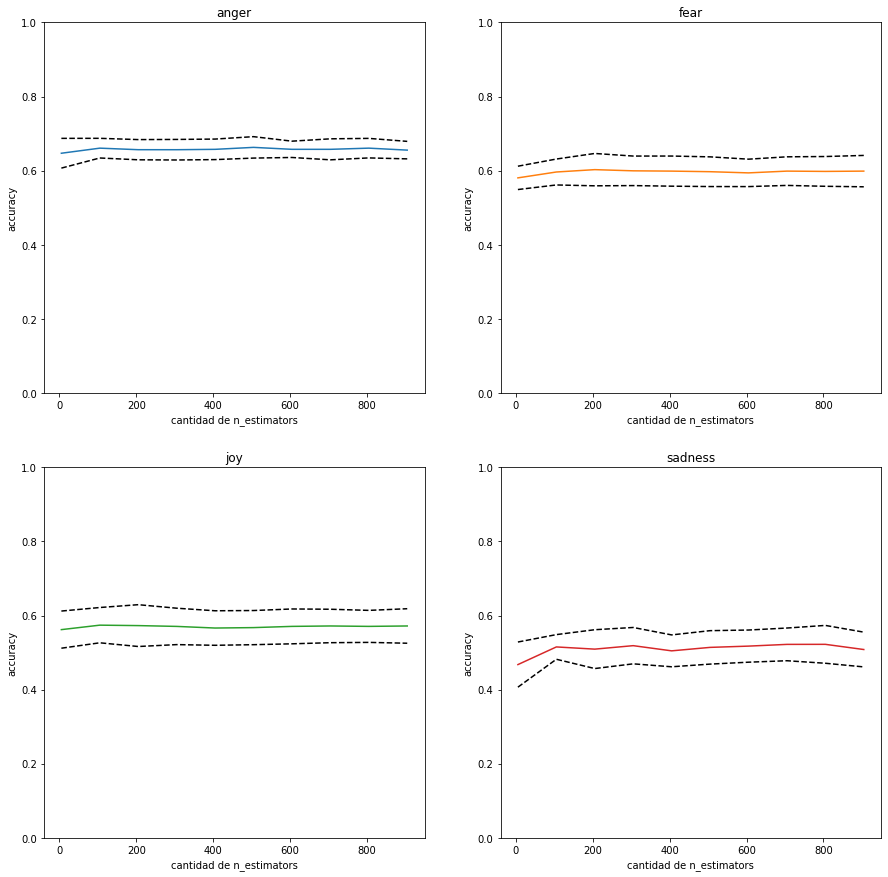

In [10]:
plot_statistics_all(train, data_keys)

metricas: kappa


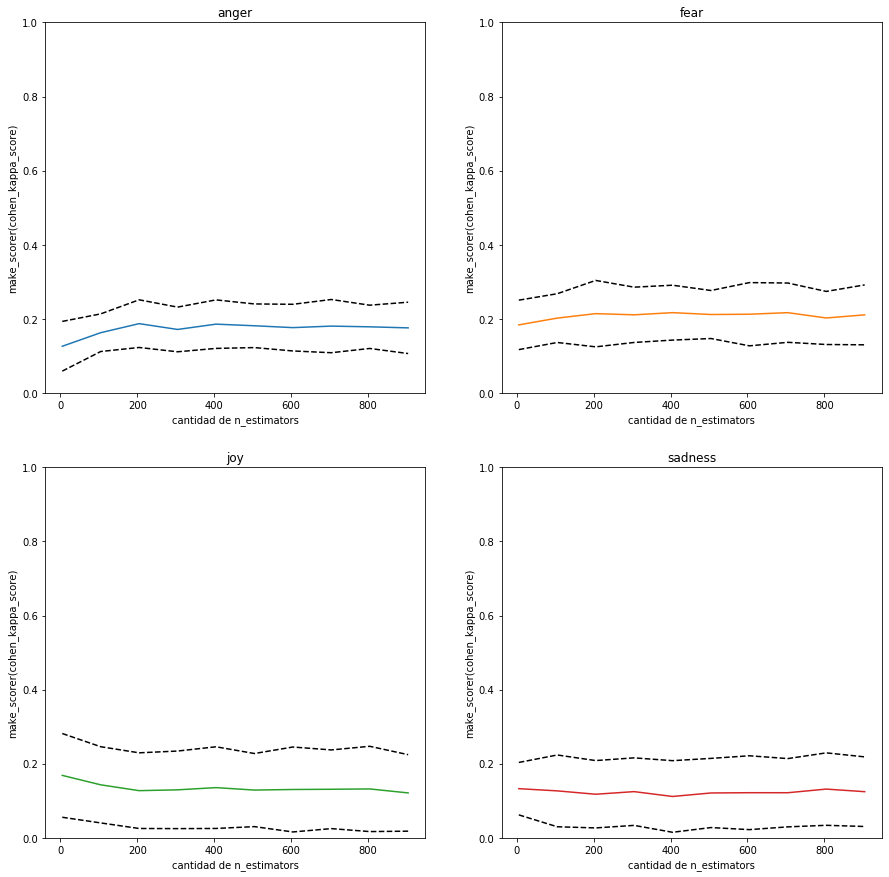

In [11]:
plot_statistics_all(train, data_keys,n_cv=10, eval_metric='kappa')

### Ejecutar el clasificador para cierto dataset

Clasifica un dataset. Retorna el modelo ya entrenado mas sus labels asociadas.


In [12]:
def classify(dataset, key):

    X_train, X_test, y_train, y_test = split_dataset(dataset)
    text_clf = get_classifier()

    # Entrenar el clasificador
    text_clf.fit(X_train, y_train)

    # Predecir las probabilidades de intensidad de cada elemento del set de prueba.
    predicted = text_clf.predict_proba(X_test)

    # Obtener las clases aprendidas.
    learned_labels = text_clf.classes_

    # Evaluar -> baseline
    evaulate(predicted, y_test, learned_labels)
    
    # Estadisticas CV
    mean, std, eval_metric = statisticsCV(text_clf, dataset, n_cv=20)
    print('{} for {}:\n'.format(eval_metric, key))
    print("mean: ", mean, "|  std: ", std)
    print('\n')
    
    
    # Estadisticas CV
    mean, std, eval_metric = statisticsCV(text_clf, dataset, n_cv=20, eval_metric=make_scorer(cohen_kappa_score))
    print('{} for {}:\n'.format(eval_metric, key))
    print("mean: ", mean, "|  std: ", std)
    print('\n')
    
    print("--------------------------------------------------------------")
    
    return text_clf, learned_labels

### Ejecutar el clasificador por cada dataset


In [13]:
classifiers = []
learned_labels_array = []

# Por cada llave en train ('anger', 'fear', 'joy', 'sadness')
for key in train:
    classifier, learned_labels = classify(train[key], key)
    classifiers.append(classifier)
    learned_labels_array.append(learned_labels)

Confusion Matrix for anger:

[[  4  44   1]
 [ 14 185  11]
 [  0  34  18]]

Classification Report
              precision    recall  f1-score   support

         low       0.22      0.08      0.12        49
      medium       0.70      0.88      0.78       210
        high       0.60      0.35      0.44        52

    accuracy                           0.67       311
   macro avg       0.51      0.44      0.45       311
weighted avg       0.61      0.67      0.62       311

auc:  0.486648131336711
kappa: 0.171707342057415
accuracy: 0.6655948553054662 

------------------------------------------------------


accuracy for anger:

mean:  0.6632335265280951 |  std:  0.05491203230892217


make_scorer(cohen_kappa_score) for anger:

mean:  0.17719800423870585 |  std:  0.11365033551563944


--------------------------------------------------------------
Confusion Matrix for fear:

[[ 25  85   0]
 [ 16 199  11]
 [  3  58  18]]

Classification Report
              precision    recall  f1-score  

## Predecir target set

In [14]:
def predict_target(dataset, classifier, labels):
    # Predecir las probabilidades de intensidad de cada elemento del target set.
    predicted = pd.DataFrame(classifier.predict_proba(dataset.tweet), columns=labels)
    # Agregar ids
    predicted['id'] = dataset.id.values
    # Reordenar
    predicted = predicted[['id', 'low', 'medium', 'high']]
    return predicted

### Ejecutar la predicción y guardar archivos.

In [15]:
predicted_target = {}

if (not os.path.isdir('./predictions')):
    os.mkdir('./predictions')

else:
    # Eliminar predicciones anteriores:
    shutil.rmtree('./predictions')
    os.mkdir('./predictions')

for idx, key in enumerate(target):
    # Predecir el target set
    predicted_target[key] = predict_target(target[key], classifiers[idx],
                                           learned_labels_array[idx])
    # Guardar predicciones
    predicted_target[key].to_csv('./predictions/{}-pred.txt'.format(key),
                                 sep='\t',
                                 header=False,
                                 index=False)

# Crear archivo zip
a = shutil.make_archive('predictions', 'zip', './predictions')